LINK to presentation slides: https://docs.google.com/presentation/d/1Cm2IDtUuRNDoVjILW_pcSzV6pH7JJMp5JMR3f9mHSpY/edit?usp=sharing

#Run below to get dataset!!!!

In [ ]:
! pip install -q kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#gitclone repo to get Kaggle API Token
!git clone https://github.com/sriveenac/ECE143_Fraud
#Download + unzip dataset
! mkdir ~/.kaggle
! cp ECE143_Fraud/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d shivamb/netflix-shows --unzip
! kaggle datasets download -d shivamb/amazon-prime-movies-and-tv-shows --unzip
! kaggle datasets download -d shivamb/hulu-movies-and-tv-shows --unzip
! kaggle datasets download -d shivamb/disney-movies-and-tv-shows --unzip
! kaggle datasets download -d shivamb/disney-movies-and-tv-shows --unzip


Cloning into 'ECE143_Fraud'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
  0% 0.00/1.34M [00:00<?, ?B/s]
100% 1.34M/1.34M [00:00<00:00, 87.2MB/s]
  0% 0.00/1.61M [00:00<?, ?B/s]
100% 1.61M/1.61M [00:00<00:00, 52.8MB/s]
  0% 0.00/421k [00:00<?, ?B/s]
100% 421k/421k [00:00<00:00, 27.3MB/s]
  0% 0.00/131k [00:00<?, ?B/s]
100% 131k/131k [00:00<00:00, 49.1MB/s]
  0% 0.00/131k [00:00<?, ?B/s]
100% 131k/131k [00:00<00:00, 46.9MB/s]


### Load Datasets + concat into one DataFrame

In [ ]:
netflix = pd.read_csv('netflix_titles.csv')
netflix['platform'] = 'netflix'
prime = pd.read_csv('amazon_prime_titles.csv')
prime['platform'] = 'prime'
disney = pd.read_csv('disney_plus_titles.csv')
disney['platform'] = 'disney'
hulu = pd.read_csv('hulu_titles.csv')
hulu['platform'] = 'hulu'
all = pd.concat([netflix,prime,disney,hulu])

In [ ]:
#more clean up for rating and duration
cond=all['rating'].str.contains("Season|min",na=False)
all.loc[cond, ['rating', 'duration']] = all.loc[cond, [ 'duration','rating']].values 
all['rating']=all['rating'].fillna('NOT RATED')
#all['rating']=all['rating'].fillna(np.nan)

all['rating']=all['rating'].replace(['TV-MA','R','18+','AGES_18_','NC-17','16+','16','AGES_16_'],[18]*8)
all['rating']=all['rating'].replace(['13+','TV-14','PG-13'],[13]*3)
all['rating']=all['rating'].replace(['ALL_AGES','ALL','G','TV-G','TV-Y'],[0]*5)
all['rating']=all['rating'].replace(['PG','TV-PG','7+','TV-Y7','TV-Y7-FV'],[7]*5)
all['rating']=all['rating'].replace(['UR','NR','UNRATED','NOT RATED','NOT_RATE','TV-NR','nan'],['NOT RATED']*7)

More clean up on rating and duration column::

In raw data，some duration data was put in rating column. do swapping

The rating standard is complicated and incompatible, simplify that into 4 levels of required age：0 for all age，7 for older kids， 13 for teens，18 for adults


In [ ]:
# Data clean up
all.duration = all.duration.str.split(' ')
def get_val(x,y = 'Seasons'):
  if isinstance(x,float):
    pass
  elif x[1] == y or x[1] == y[:-1]:

      return x[0]
all["num_seasons"] = all.duration.apply(lambda x: get_val(x, 'Seasons'))
all["length"] = all.duration.apply(lambda x: get_val(x, 'mins') )
all = all.fillna(value=np.nan)
all.duration = all.duration.astype(str)
all.length = all.length.astype(float)
all.num_seasons = all.num_seasons.astype(float)

### Count Null Values 

In [ ]:
nulls = all.set_index('platform').isna().sum(level=0)
counts = all.groupby('platform').nunique()
per_null = counts.loc[:,['show_id','title']]
per_null[['null_directors','null_cast','null_country', 'null_date_added','null_rating', 'null_duration']]= nulls.loc[:,['director', 'cast','country','date_added','rating','duration']]
per_null['null_cast'] = (per_null.null_cast/per_null.show_id)*100
per_null['null_country'] = (per_null.null_country/per_null.show_id)*100
per_null['null_date_added'] = (per_null.null_date_added/per_null.show_id)*100
per_null['null_rating'] = (per_null.null_rating/per_null.show_id)*100
per_null['null_duration'] = (per_null.null_duration/per_null.show_id)*100
per_null['null_directors'] = (per_null.null_directors/per_null.show_id)*100
per_null

,show_id,title,null_directors,null_cast,null_country,null_date_added,null_rating,null_duration
platform,,,,,,,,
disney,1450,1450,32.620690,13.103448,15.103448,0.206897,0.0,0.0
hulu,3073,3073,99.902376,100.000000,47.282786,0.911162,0.0,0.0
netflix,8807,8807,29.908028,9.367549,9.435676,0.113546,0.0,0.0
prime,9668,9668,21.534961,12.753413,93.049235,98.396773,0.0,0.0


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

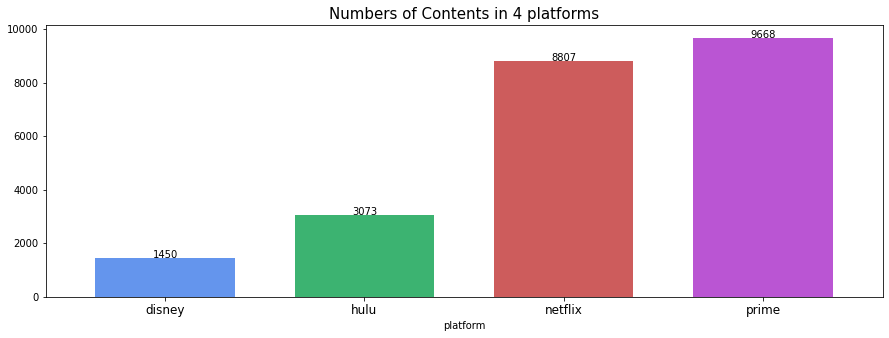

In [ ]:
colors = ['cornflowerblue','mediumseagreen','indianred','mediumorchid']
fig=plt.figure(figsize = (15,5))
per_null['show_id'].plot(kind='bar',color=colors,width=0.7)

x = ["disney", "hulu", "netflix", "prime"]
y = [1450, 3073, 8807, 9668]
  
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i],size=10, ha = 'center')
addlabels(x, y)
plt.title('Numbers of Contents in 4 platforms',size=15)
plt.xticks(size=12,rotation=0)

Since Directors and Cast are nulls for over 50% of the data: we will remove these columns for all analyses \

For analyses on country: we exclude Amazon Prime and Hulu data has high null values. \ 
For Analyses on data added: We exclude Amazon Prime since 98% of this data is null. \

For the majority of the analyses: we exclude Hulu Data since it has high % of nulls for many of the columns (specifically rating and duration), and exclude rows from other platforms that have null in these columns for our Master Table below.

### Creating Country, Date_Added, and Master Tables for 3 levels of analysis

In [ ]:
master = all.loc[:,['show_id', 'type', 'title','release_year','rating','duration','listed_in','description','platform']]
master = master.dropna()
master = master[master.platform != 'hulu']
country = all[~all.platform.isin(['prime', 'hulu'])] # analyze the countries
added = all[~all.platform.isin(['prime'])] # when things are being added


Moving forward, we use "master" for all analysis and "country" and "added" for their respective EDAs

In [ ]:
master.platform.unique()

array(['netflix', 'prime', 'disney'], dtype=object)

## Correlations among different platforms

Setup：Colors for each platform

If think it's ugly, feel free to change it

In [ ]:
custom_colors = ['cornflowerblue','mediumseagreen','indianred','mediumorchid']


disney_p = sns.light_palette(custom_colors[0], reverse=True)
hulu_p = sns.light_palette(custom_colors[1], reverse=True)
netflix_p = sns.light_palette(custom_colors[2], reverse=True)
prime_p = sns.light_palette(custom_colors[3], reverse=True)



Study Question 1: Which platform has more movies than TV shows?

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from pylab import rcParams
df_disney = master[master.platform == 'disney']
df_netflix = master[master.platform == 'netflix']
df_prime = master[master.platform == 'prime']
# ax1 = df_disney['type'].value_counts().plot(kind='bar')
print('disney platform:\n', df_disney['type'].value_counts())
# ax1.set_title("Disney: Distribution of TV Shows vs Movies")

# ax2 = df_netflix['type'].value_counts().plot(kind='bar')
# ax2.set_title("Netflix: Distribution of TV Shows vs Movies")
print('netflix platform:\n',df_netflix['type'].value_counts())

# ax3 = df_prime['type'].value_counts().plot(kind='bar')
# ax3.set_title("Prime: Distribution of TV Shows vs Movies")
print('prime platform:\n',df_prime['type'].value_counts())
# plt.show()
print('hulu platform:\n',hulu['type'].value_counts())

disney platform:
 Movie      1052
TV Show     398
Name: type, dtype: int64
netflix platform:
 Movie      6131
TV Show    2676
Name: type, dtype: int64
prime platform:
 Movie      7814
TV Show    1854
Name: type, dtype: int64
hulu platform:
 TV Show    1589
Movie      1484
Name: type, dtype: int64


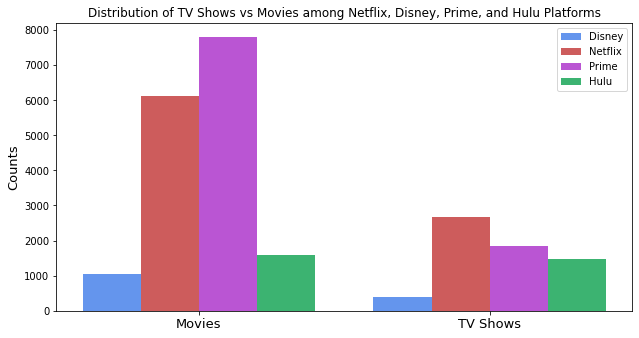

In [ ]:
# combining three platforms in one figure
disney=[1052,398]
netflix=[6131,2676]
prime=[7814,1854]
hulu=[1589,1484]
X = np.arange(2)
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, disney, width = 0.2,label='Disney',color='cornflowerblue')
ax.bar(X + 0.2, netflix, width = 0.2, label='Netflix',color='indianred')
ax.bar(X + 2*0.2, prime, width = 0.2, label='Prime',color='mediumorchid')
ax.bar(X + 3*0.2, hulu, width = 0.2, label='Hulu',color='mediumseagreen')
plt.xticks([r+0.3 for r in range(2)],['Movies', 'TV Shows'],fontsize=13)
rcParams['figure.figsize'] = 10, 5
#plt.xlabel('Types')
plt.ylabel('Counts',fontsize=13)
plt.title('Distribution of TV Shows vs Movies among Netflix, Disney, Prime, and Hulu Platforms')
plt.legend()
plt.show()

Study Results 1: Prime has more movies comparing to Disney and Netflix, while Netflix has more TV Shows comparing to the rest of others.

Sub Question : Which platform has most movies/TV shows? 


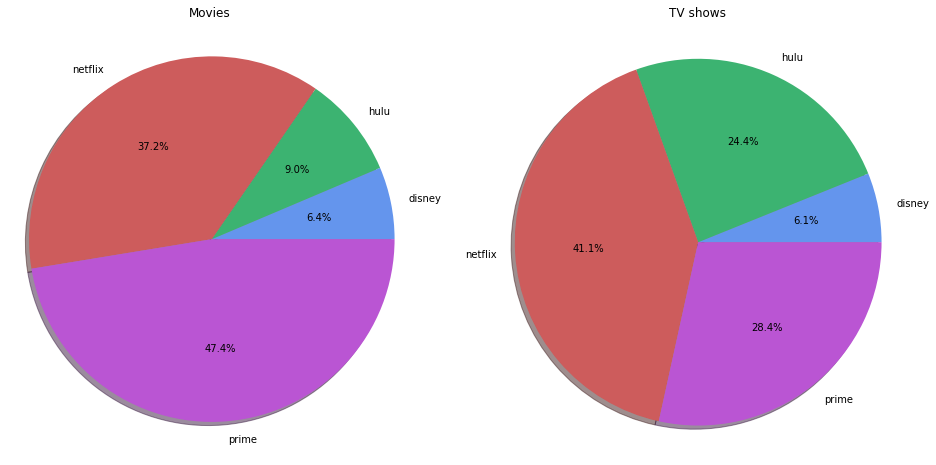

In [ ]:
portion=all.groupby(['type','platform']).size()

fig = plt.subplots(figsize=(16, 8))
labels = portion.Movie.index

sizes1 =portion.Movie.values
sizes2 = portion['TV Show'].values
# custom_colors = ['cornflowerblue','hotpink','orange','seagreen']
custom_colors = ['cornflowerblue','mediumseagreen','indianred','mediumorchid']

colors = custom_colors
explode = (0, 0, 0, 0) 

def pie2(i,sizes,colors,title):
    plt.subplot(i)
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True)
    fig = plt.gcf()
    #fig.gca().add_artist(centre_circle)
    plt.title(title)
    plt.axis('equal')
pie2(121,sizes1,colors,'Movies')
pie2(122,sizes2,colors,'TV shows')
plt.show()

conclusion: prime wins on movie and netflix wins on TV show

subquestion : ratio of movies and TV shows on each platform

Index(['Movie', 'TV Show'], dtype='object', name='type')


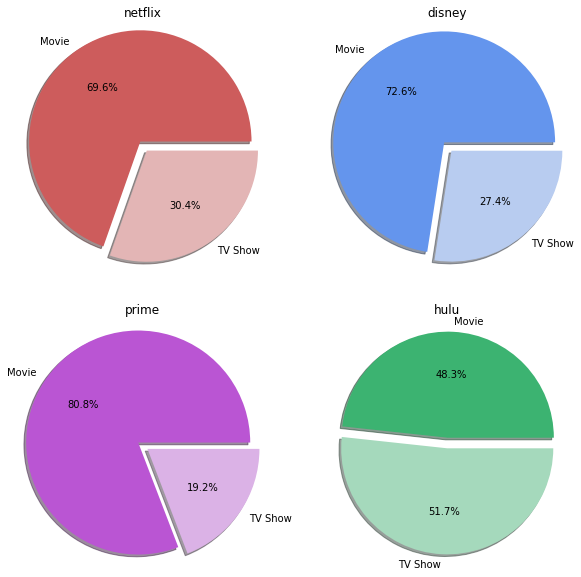

In [ ]:
plt.figure(figsize=(10,10))
size1=portion[:,'prime'].values
labels=portion[:,'prime'].index
explode = (0.1,0) 
print(labels)
size2=portion[:,'netflix'].values

size3=portion[:,'hulu'].values

size4=portion[:,'disney'].values
#colors=netflix_p
pie2(223,size1,[list(prime_p)[0],list(prime_p)[3]],'prime')
pie2(221,size2,[list(netflix_p)[0],list(netflix_p)[3]],'netflix')
pie2(224,size3,[list(hulu_p)[0],list(hulu_p)[3]],'hulu')
pie2(222,size4,[list(disney_p)[0],list(disney_p)[3]],'disney')

Movie is the main content for Netflix, Disney and Prime.  But Hulu has almost as many movies as TV shows.  

Study Question 2: Which platform has more diversities in countries?

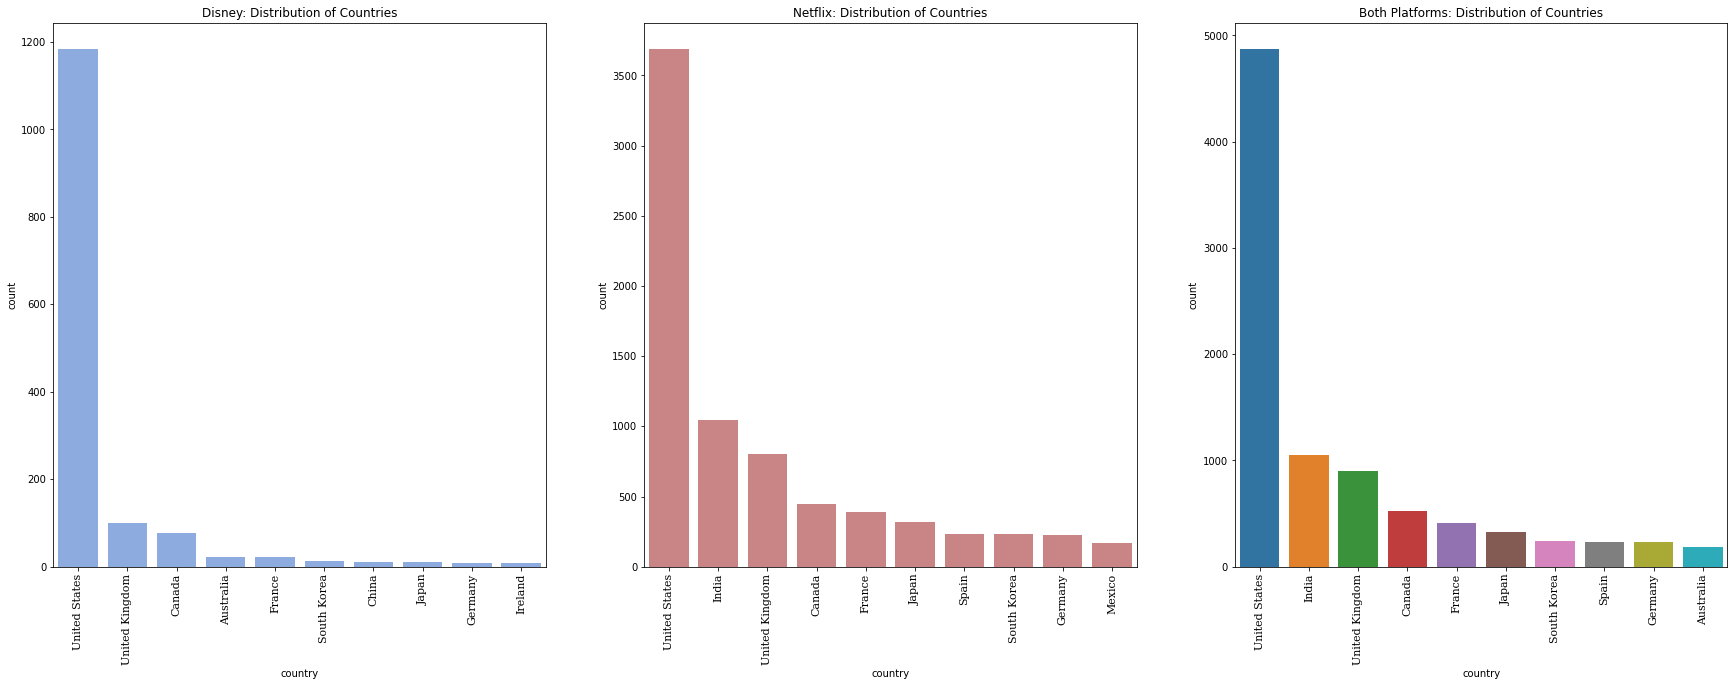

In [ ]:
import seaborn as sns

country_disney = country[country.platform == 'disney']
country_netflix = country[country.platform == 'netflix']
fig, axes = plt.subplots(1, 3,figsize=(30,10))
cc  =country['country'].str.split(', ').explode().value_counts()
cc_disney =country_disney['country'].str.split(', ').explode().value_counts()
cc_netflix =country_netflix['country'].str.split(', ').explode().value_counts()
sns.countplot(ax = axes[0],x = country_disney['country'].str.split(', ').explode(), order=cc_disney.index[0:10], color=disney_p[1])
axes[0].set_title("Disney: Distribution of Countries")
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)
sns.countplot(ax = axes[1],x = country_netflix['country'].str.split(', ').explode(), order=cc_netflix.index[0:10], color=netflix_p[1])
axes[1].set_title("Netflix: Distribution of Countries")
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)
sns.countplot(ax = axes[2],x = country['country'].str.split(', ').explode(), order=cc.index[0:10])
axes[2].set_title("Both Platforms: Distribution of Countries")
axes[2].set_xticklabels(axes[2].get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

plt.show()



Study Results 2: 
Netflix has movies from more countries- more diverse movies. \
Indian movies are the second most common movies in Netflix whereas disney doesn't have any from India. \
 
**Go to Netflix for international movies and Disney for American movies**

Study Question 3: Which platform has more recently released movies or TV Shows?

In [ ]:
master[['platform','release_year','type','title']].groupby(['platform','release_year','type']).describe()

title  ...     
                              count  ... freq
platform release_year type           ...     
disney   1928         Movie       1  ...    1
         1932         Movie       3  ...    1
         1933         Movie       3  ...    1
         1934         Movie       4  ...    1
         1935         Movie       4  ...    1
...                             ...  ...  ...
prime    2019         TV Show   199  ...    1
         2020         Movie     736  ...    1
                      TV Show   226  ...    1
         2021         Movie    1139  ...    1
                      TV Show   303  ...    1

[408 rows x 4 columns]

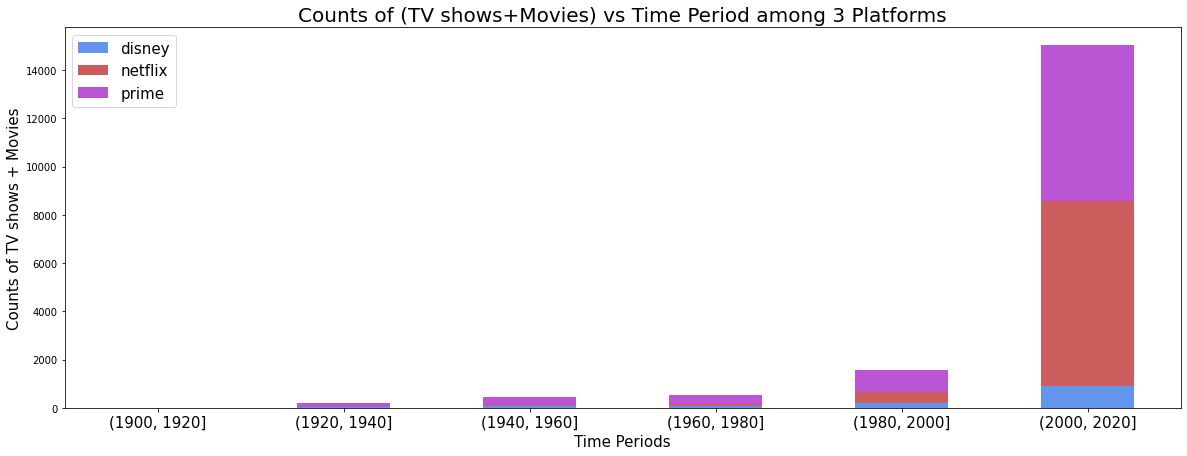

In [ ]:
# change to stackplot
#1920-1960
#1960-1980
#1980-2000
plt.rcParams["figure.figsize"] = (20,7)
# ls=[df_disney.release_year.sort_values().tolist(),df_netflix.release_year.sort_values().tolist(),df_prime.release_year.sort_values().tolist()]
# df=pd.DataFrame(ls,index=['Disney','Netflix','Prime'])
df=master[['platform','release_year']]
bins = [1900, 1920, 1940, 1960, 1980, 2000,2020]
groups = df.groupby(['platform', pd.cut(df.release_year, bins)])
table=groups.size().unstack().T
table.plot(kind='bar', stacked=True,color=['cornflowerblue','indianred','mediumorchid'])
plt.title('Counts of (TV shows+Movies) vs Time Period among 3 Platforms',fontsize=20)
plt.xticks(rotation=0, ha='center',fontsize=15)
plt.ylabel('Counts of TV shows + Movies',fontsize=15)
plt.xlabel('Time Periods',fontsize=15)
plt.legend(prop={"size":15})


In [ ]:
table['prime']/table['prime'].sum()*100

release_year
(1900, 1920]     0.036470
(1920, 1940]     2.090931
(1940, 1960]     3.938731
(1960, 1980]     4.206176
(1980, 2000]    11.329929
(2000, 2020]    78.397763
Name: prime, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6862a4cd90>,
      dtype=object)

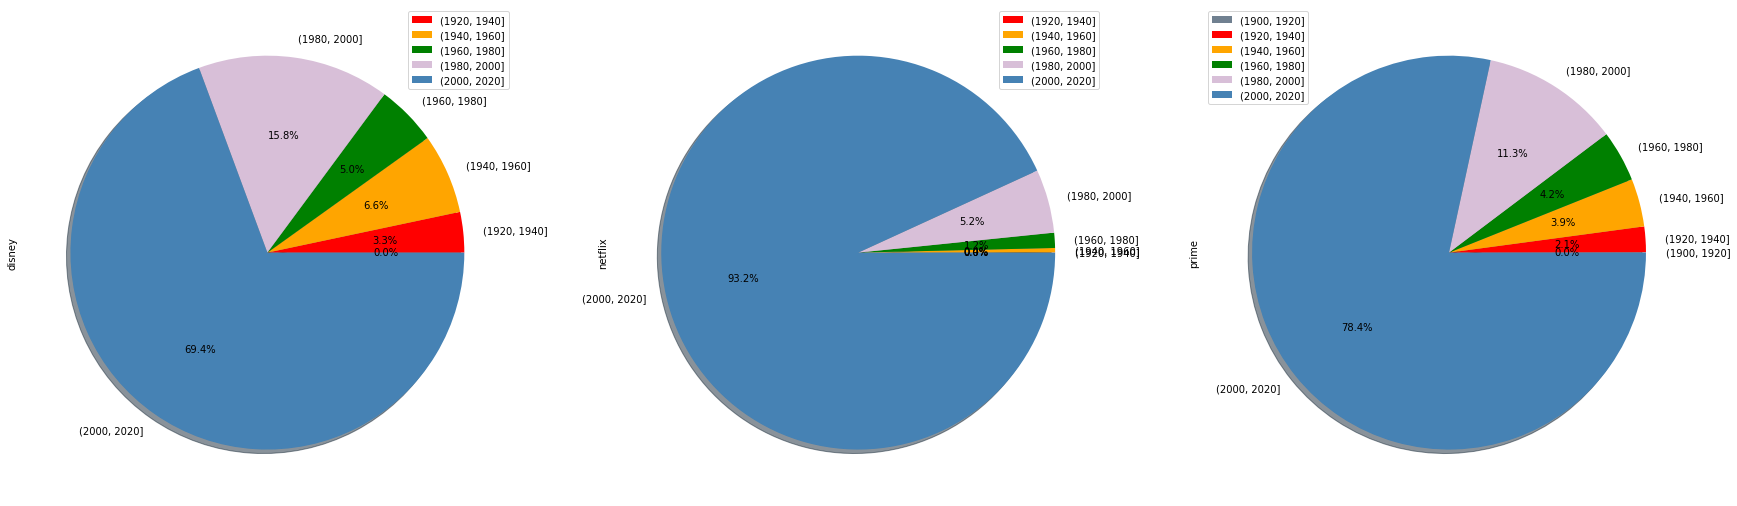

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)

table.plot(kind="pie",subplots=True, shadow = True,autopct='%1.1f%%',colors = ['slategrey','red','orange','green','thistle','steelblue'], fontsize=10)


Study Results 3: The graph above shows that Netflix has the most amount of recently released shows (both movies and tv shows) comparing to others, while prime has more older shows/videos in the past (from 1920 till around 2000).

Study Question 4: Which genres have the toppest amount in different platforms?

In [ ]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        pct=round(pct,2)
        val = int(round(pct*total/100.0))
        # print(val)
        return '{:.2f}%\n({:.0f})'.format(pct, val)
    return my_format

def split_lists(input_df,name,c):
  ls=input_df['listed_in'].tolist()
  res_ls=[]
  for i in ls:
    if ', ' in i:
      w=i.split(', ')
      res_ls.append([k for k in w])
    else:
      res_ls.append([i])
  final=[b for a in res_ls for b in a]
  df=pd.DataFrame(final)
  df=df.reset_index().rename(columns={"index":"count",0:"genre"}).groupby('genre').count()
  df=df.sort_values(by='count',ascending=False).head(10)
  df.plot.bar(figsize=(15, 5),color=c)
  plt.title(name,fontweight="bold")
  df.plot.pie(y='count',autopct=autopct_format(df['count']), figsize=(15, 15),shadow=True)
  plt.title(name,fontweight="bold")
  return 


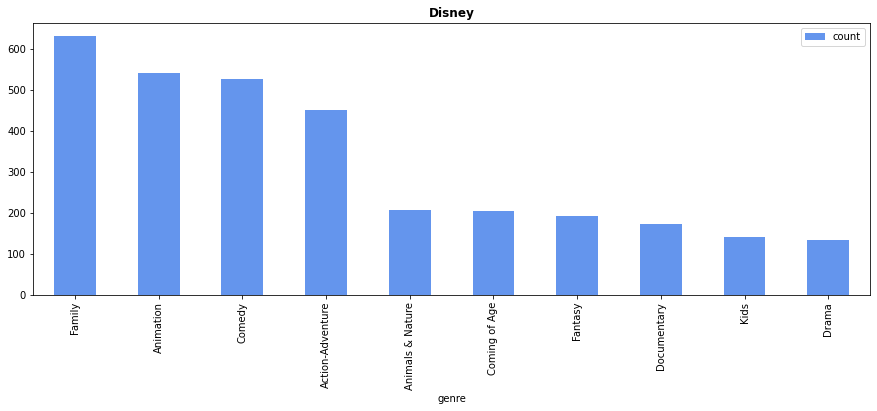

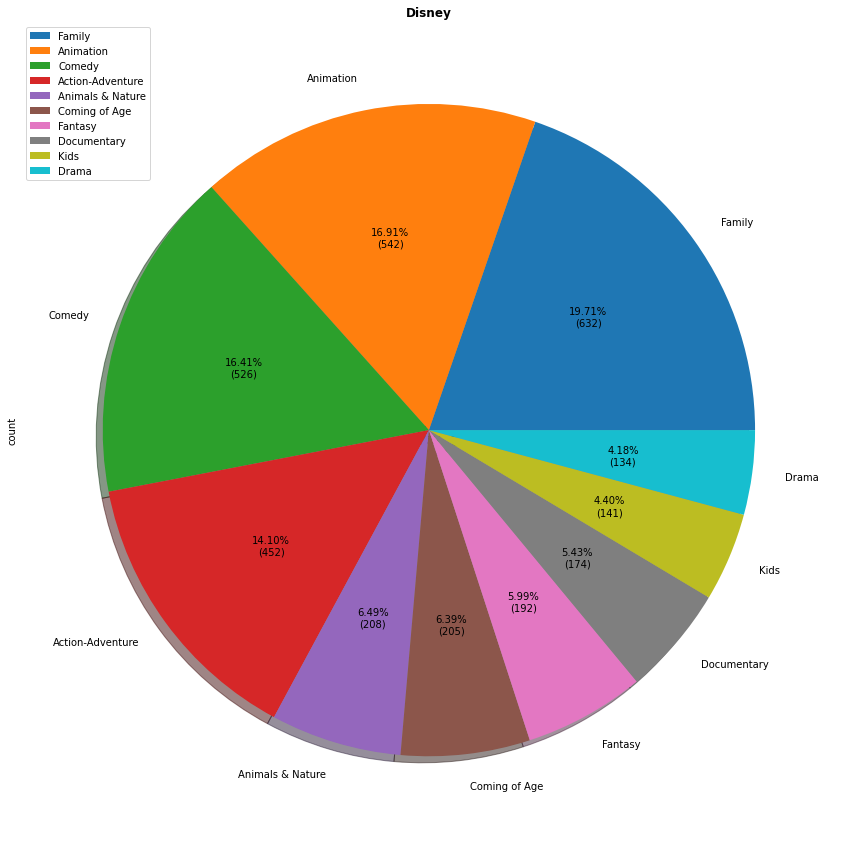

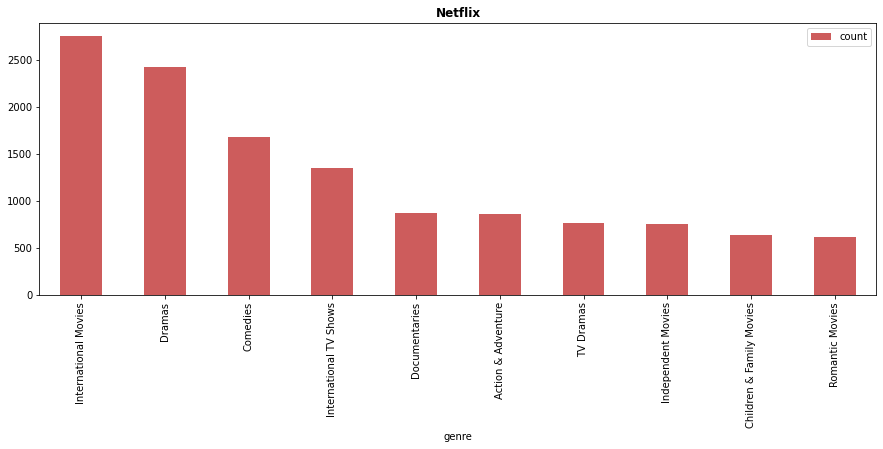

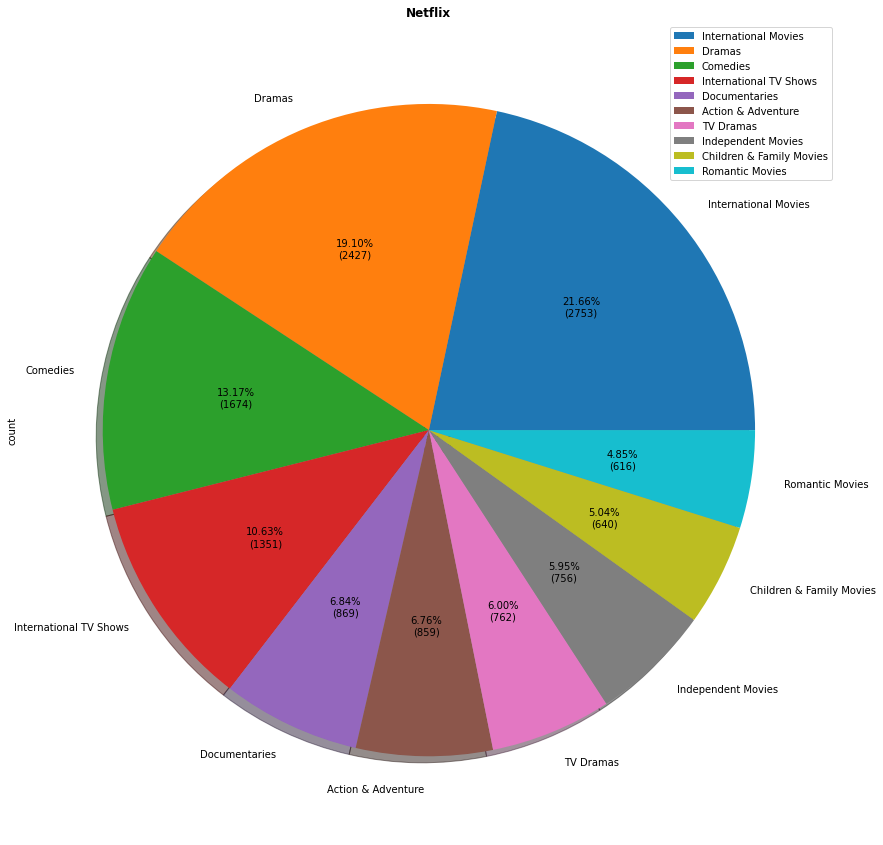

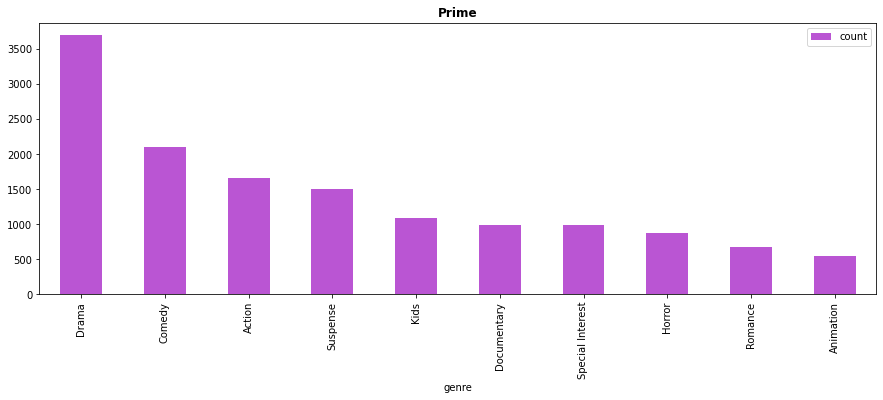

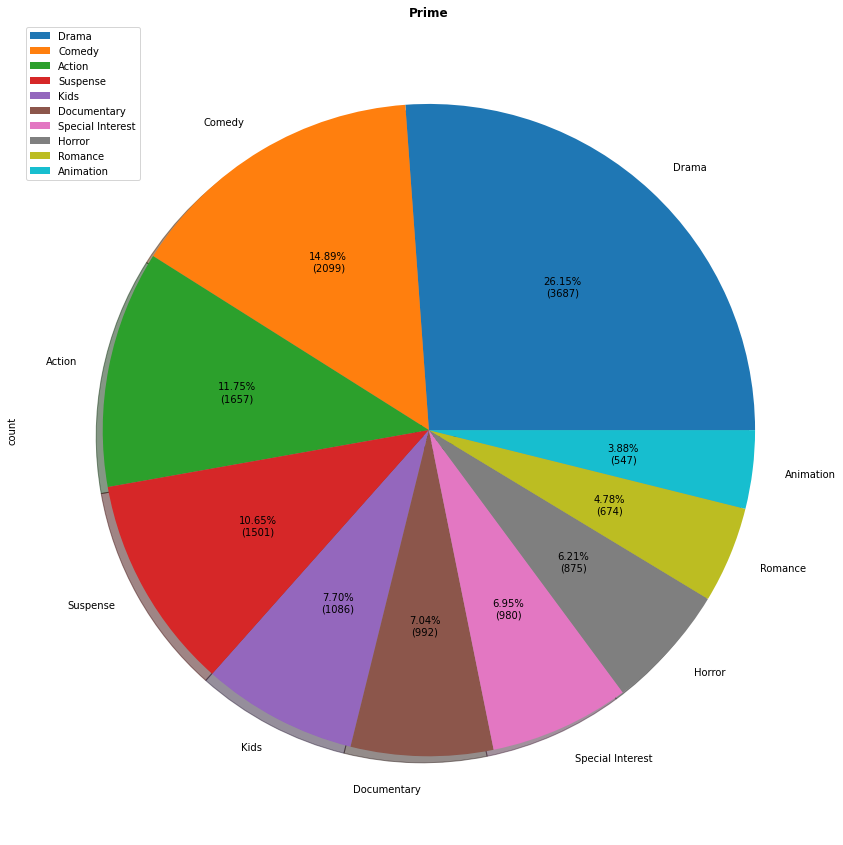

In [ ]:

split_lists(df_disney,'Disney','cornflowerblue')
split_lists(df_netflix,'Netflix','indianred')
split_lists(df_prime,'Prime','mediumorchid')

Study Results 4: The top 10 genres selections among Disney, Netflix, and Prime are shown in pie chart above.

Study Question 5: rating.


In [ ]:
rate=all
rate=rate[~rate['rating'].isin(['NOT RATED'])]
rate['rating'].value_counts()

18    8631
13    6367
7     3489
0     2903
Name: rating, dtype: int64

throw away all the unrated entries. Another choice is treat them as 'for all age'.


In [ ]:
def barplot(i,dataframe,platform,p):
    plt.subplot(i)
    dataframe=dataframe.loc[dataframe['platform'] == platform]
    dataframe = dataframe['rating'].value_counts().reset_index()
    dataframe.columns=['age','count']


    sns.barplot(x="age", y="count", data=dataframe,palette=p)
    plt.xlabel('Age', fontsize = 10)
    plt.title(platform, fontsize = 14)
    plt.ylabel('count', fontsize = 10)


[Text(0, 0, 'Kids'), Text(0, 0, 'Older Kids'), Text(0, 0, 'Teens')]

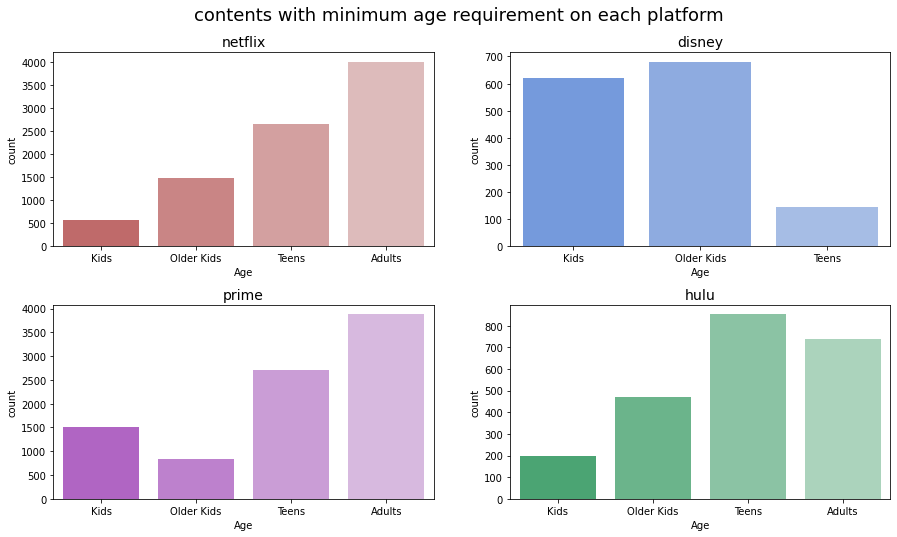

In [ ]:

fig=plt.figure(figsize = (15, 8))
fig.subplots_adjust(top=0.9)
plt.suptitle('contents with minimum age requirement on each platform',fontsize = 18)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
#custom_colors = ['cornflowerblue','hotpink','orange','seagreen']

barplot(221,rate,'netflix',netflix_p)
xticklabel_list=['Kids','Older Kids','Teens','Adults']
plt.gca().set_xticklabels(xticklabel_list)
barplot(224,rate,'hulu',hulu_p)
plt.gca().set_xticklabels(xticklabel_list)
barplot(223,rate,'prime',prime_p)
plt.gca().set_xticklabels(xticklabel_list)
barplot(222,rate,'disney',disney_p)
xticklabel_list=['Kids','Older Kids','Teens']
plt.gca().set_xticklabels(xticklabel_list)

On most platforms， adult content account for the most（ Hulu has a slightly smaller percentage, but given that many of its contents are unrated，We can still make this conclusion）  Disney has no content unsuitable for children  

sub question:Which platform has the most content for kids<=7?

Text(0.5, 1.0, 'Hulu')

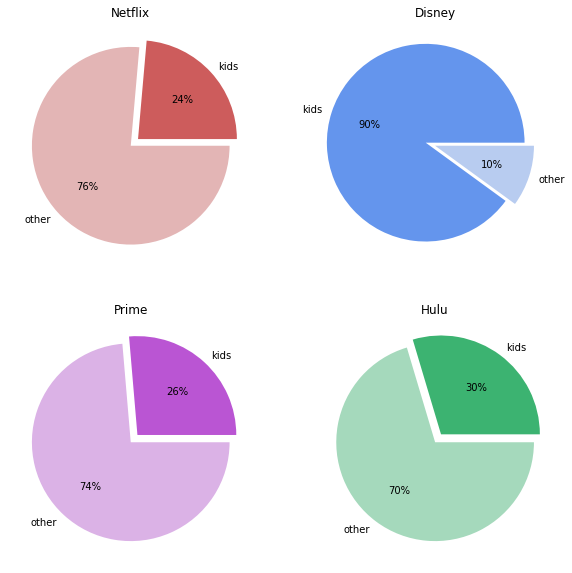

In [ ]:
labels='kids','other'
# sizes=[kids_ratio,1-kids_ratio]

explode=(0.1,0)
# plt.pie(sizes,explode=explode,labels=labels,autopct='%1.0f%%')
# plt.gca().set_title('all platforms')
kids_ratio_netflix=(rate[(rate['rating']<=7)&(rate['platform']=='netflix')].shape[0])/rate[rate['platform']=='netflix'].shape[0]
kids_ratio_disney=(rate[(rate['rating']<=7)&(rate['platform']=='disney')].shape[0])/rate[rate['platform']=='disney'].shape[0]
kids_ratio_prime=(rate[(rate['rating']<=7)&(rate['platform']=='prime')].shape[0])/rate[rate['platform']=='prime'].shape[0]
kids_ratio_hulu=(rate[(rate['rating']<=7)&(rate['platform']=='hulu')].shape[0])/rate[rate['platform']=='hulu'].shape[0]
plt.figure(figsize=(10,10))
size_netflix=[kids_ratio_netflix,1-kids_ratio_netflix]
size_disney=[kids_ratio_disney,1-kids_ratio_disney]
size_prime=[kids_ratio_prime,1-kids_ratio_prime]
size_hulu=[kids_ratio_hulu,1-kids_ratio_hulu]
axe1=plt.subplot(2,2,1)
axe2=plt.subplot(2,2,2)
axe3=plt.subplot(2,2,3)
axe4=plt.subplot(2,2,4)

axe1.pie(size_netflix,explode=explode,labels=labels,colors=[list(netflix_p)[0],list(netflix_p)[3]],autopct='%1.0f%%')
axe1.set_title('Netflix')
axe2.pie(size_disney,explode=explode,labels=labels,colors=[list(disney_p)[0],list(disney_p)[3]],autopct='%1.0f%%')
axe2.set_title('Disney')
axe3.pie(size_prime,explode=explode,labels=labels,colors=[list(prime_p)[0],list(prime_p)[3]],autopct='%1.0f%%')
axe3.set_title('Prime')
axe4.pie(size_hulu,explode=explode,labels=labels,colors=[list(hulu_p)[0],list(hulu_p)[3]],autopct='%1.0f%%')
axe4.set_title('Hulu')

conclusion:Disney has most content for children

Study Question 6: movies duration and tv seasons




In [ ]:
Movie_Time=all[all['type']=='Movie'].dropna(subset=['length'])
TV_Season=all[all['type']=='TV Show'].dropna(subset=['num_seasons'])

In [ ]:
Movie_Time['length']=Movie_Time['length'].astype(int)
TV_Season['num_seasons']=TV_Season['num_seasons'].astype(int)

In [ ]:
def dist(i,platform,c):
    plt.subplot(i)
    Mdf=Movie_Time[Movie_Time['platform']==platform]
    sns.distplot(Mdf['length'], color=custom_colors[c],kde=True)
    plt.xlim(0,200)
    plt.xlabel('Minutes', fontsize = 12)
    plt.ylabel(platform, fontsize = 15)
    if i==421:
       plt.title('Movie Duration', fontsize = 15)
    plt.subplot(i+1)
    Tdf=TV_Season[TV_Season['platform'] == platform]
    Tdff= Tdf['num_seasons'].value_counts().reset_index()
    sns.barplot(x='index', y='num_seasons',data=Tdff,color=custom_colors[c])
    plt.xlabel('Seasons', fontsize = 12)
    plt.ylabel('')
    plt.xlim(0,10)
    if i==421:
       plt.title('TV Season', fontsize = 15)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

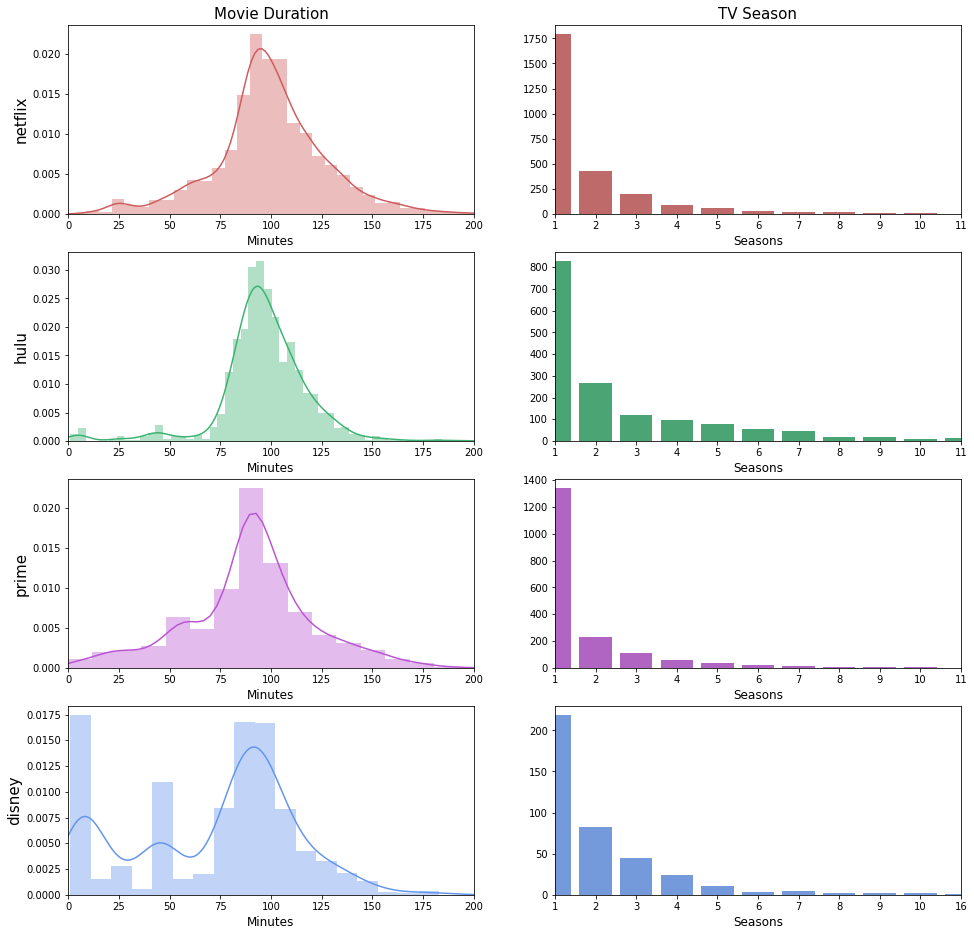

In [ ]:
plt.figure(figsize = (16, 16))

dist(421,'netflix',2)

dist(427,'disney',0)
dist(425,'prime',3)
dist(423,'hulu',1)


conclusion::

Most films are around 100 minutes long. Disney has many short movies.  

Most tv shows are within three seasons  

## Correlation within each platform

Study Question 7: tv shows vs movies

In [ ]:
def tv_movie_num(platform, color):
  # num of tv and movies
  df = master[master.platform == platform]
  movies = (df.type == 'Movie').sum()
  tvs = (df.type == 'TV Show').sum()
  fig = plt.figure(figsize = (5, 7))
  plt.bar(['Movies','TV Shows'], [movies,tvs], color = color, width = 0.6)

In [ ]:
# country num of movies and tv
def tv_movie_country(platform, color):
  plat = country[country.platform == platform]
  plat_movies = plat[plat.type == 'Movie']
  plat_tvs = plat[plat.type == 'TV Show']
  unique_movie_country = plat_movies['country'].str.split(', ').explode().value_counts()
  unique_tv_country = plat_tvs['country'].str.split(', ').explode().value_counts()
  n_movie = len(unique_movie_country)
  n_tv = len(unique_tv_country)
  fig = plt.figure(figsize = (5, 7))
  plt.bar(['Movies','TV Shows'], [n_movie,n_tv], color = color, width = 0.6)

Netflix

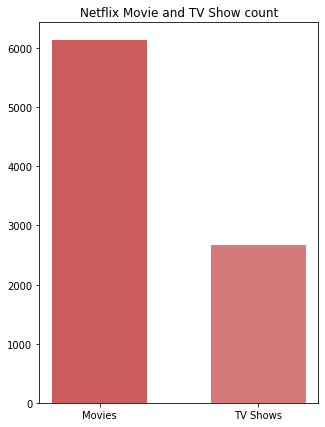

In [ ]:
tv_movie_num('netflix', netflix_p)
plt.title('Netflix Movie and TV Show count')
plt.show()

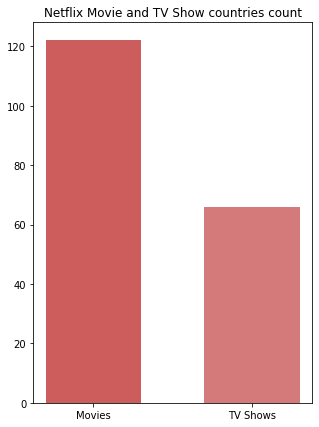

In [ ]:
tv_movie_country('netflix', netflix_p)
plt.title('Netflix Movie and TV Show countries count')
plt.show()

Netflix has more movies than tv shows. Movies on netflix are from more countries compared with tv shows.

Disney

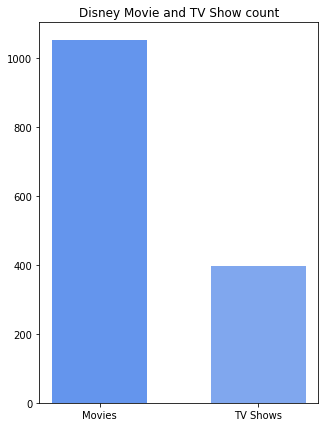

In [ ]:
tv_movie_num('disney', disney_p)
plt.title('Disney Movie and TV Show count')
plt.show()

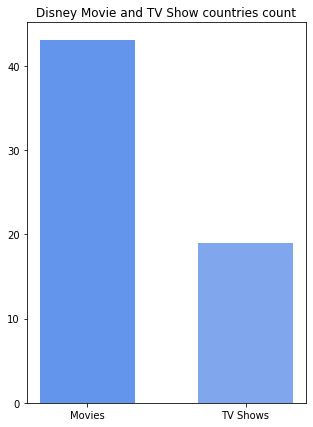

In [ ]:
tv_movie_country('disney', disney_p)
plt.title('Disney Movie and TV Show countries count')
plt.show()

Disney has more movies than tv shows. Movies on disney are from more countries compared with tv shows.

Prime

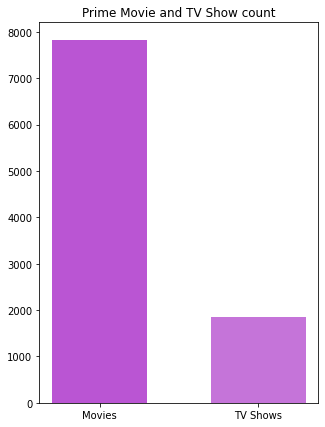

In [ ]:
tv_movie_num('prime', prime_p)
plt.title('Prime Movie and TV Show count')
plt.show()

Prime has more movies than tv shows.

Study Question 8:

In [ ]:
country.groupby('country').agg({'num_seasons': ['mean']}).dropna()

custom_colors = {'orange','hotpink','seagreen','cornflowerblue'}

In [ ]:
country_disney.duration

0         ['23', 'min']
1         ['91', 'min']
2         ['23', 'min']
3         ['41', 'min']
4       ['1', 'Season']
             ...       
1445     ['108', 'min']
1446     ['106', 'min']
1447     ['107', 'min']
1448     ['112', 'min']
1449       ['2', 'min']
Name: duration, Length: 1450, dtype: object

## Country-wise analysis 

In [ ]:
# Find TV-shows/movie split between countries
country1=country.copy()
country1['country']=country['country'].str.split(', ')
country1=country1.explode('country')

def plot_horizontal(country, color): 
  c_split=country[['type', 'country']].groupby('country')['type'].value_counts().unstack().loc[country['country'].value_counts().index[:10]]
  c_split['Total']=c_split.sum(axis=1)
  c_split['ratio']=c_split['TV Show']/c_split['Total']
  c_split=c_split.sort_values(by='ratio' )[::-1]
  plt.figure(figsize=(10,8))
  tv = plt.barh(c_split.index, c_split['TV Show']/c_split['Total'], color=color[1])
  movie = plt.barh(c_split.index, c_split['Movie']/c_split['Total'], left=c_split['TV Show']/c_split['Total'], color=color[3])
  i=0
  for p in movie:
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      plt.text(x+width/2,
              y+height/2,
              f"{c_split['Movie'][i]*100/c_split['Total'][i]:1.0f}%",ha='center', 
              fontsize=10, fontfamily='serif')
      i=i+1

  i=0
  for p in tv:
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      plt.text(x+width/2,
              y+height/2,
              f"{c_split['TV Show'][i]*100/c_split['Total'][i]:1.0f}%", ha='center',
              fontsize=10, fontfamily='serif')
      i=i+1
  plt.legend([tv, movie], ["TV Show", "Movie"],  loc="upper right")
  plt.xticks([])

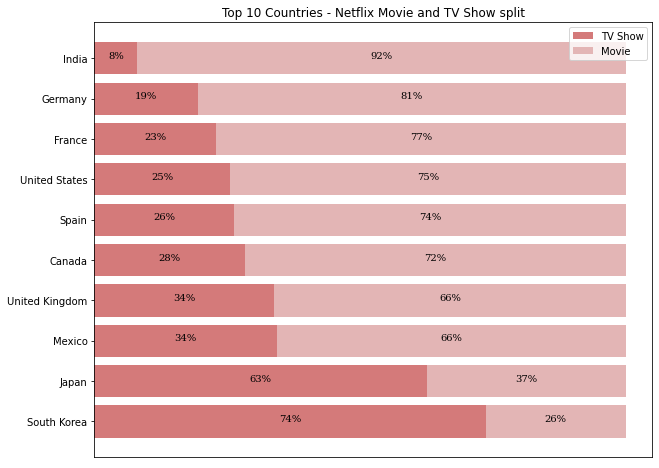

In [ ]:
plot_horizontal(country1[country1.platform=='netflix'],netflix_p)
plt.title('Top 10 Countries - Netflix Movie and TV Show split')
plt.show()

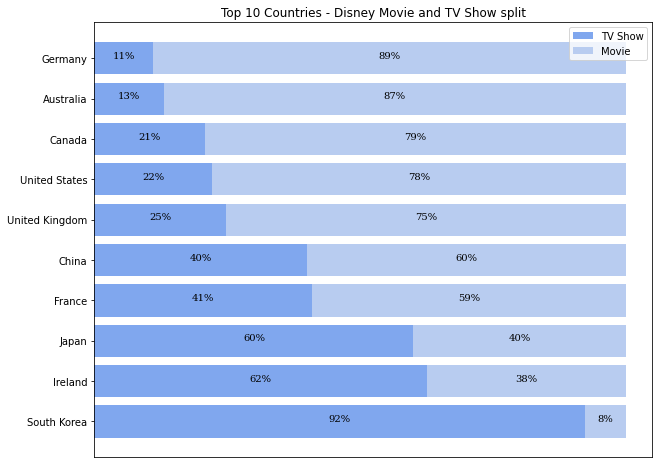

In [ ]:
plot_horizontal(country1[country1.platform=='disney'], disney_p)
plt.title('Top 10 Countries - Disney Movie and TV Show split')
plt.show()

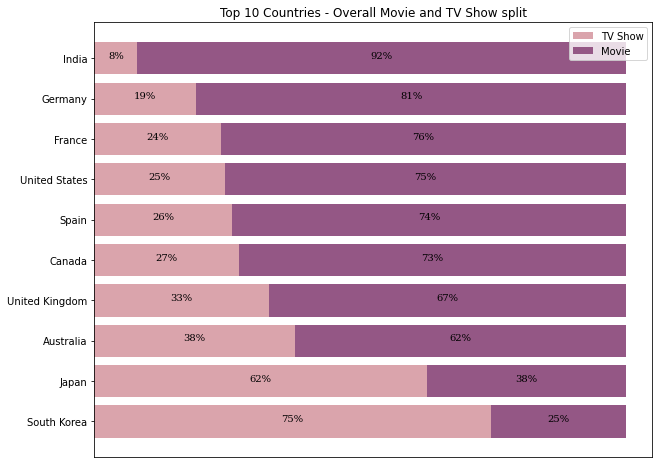

In [ ]:
plot_horizontal(country1, sns.cubehelix_palette())
plt.title('Top 10 Countries - Overall Movie and TV Show split')
plt.show()

On both Netflix and Disney, South Korea has the highest ratio of TV Shows to Movies. K-dramas are really popular and could be a contributing factor.

Overall and particularly on Netflix, India has the highest percentage of movies. 

Analysis on content added over the years 

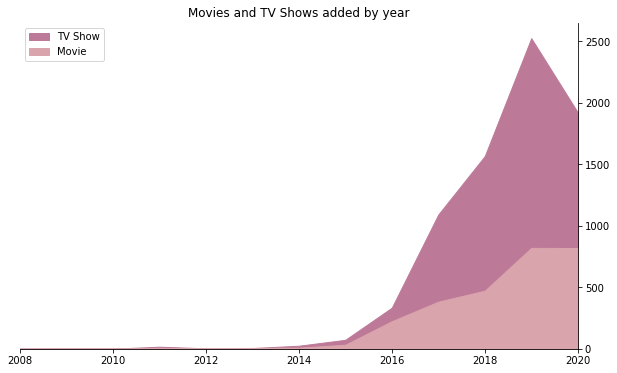

In [ ]:
country1=country.copy()
country1["date_added"] = pd.to_datetime(country1['date_added'])
country1['year_added'] = country1['date_added'].dt.year

country1['country']=country1['country'].str.split(', ')
country1=country1.explode('country')
mov=country1[country1['type']=='Movie']['year_added'].value_counts().sort_index()
tv=country1[country1['type']=='TV Show']['year_added'].value_counts().sort_index()

def plot_fill(mov,tv,color):
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
  ax.stackplot(mov.index, mov, color=color[2])
  ax.stackplot(tv.index, tv,color=color[1])
  ax.legend(["TV Show", "Movie"],  loc="upper left")
  ax.yaxis.tick_right() 
  ax.spines['top'].set_visible(False)  
  ax.spines['left'].set_visible(False)  
  ax.set_xlim(2008,2020)
  ax.set_title('Movies and TV Shows added by year')

plot_fill(mov,tv,sns.cubehelix_palette())
plt.show()

In [ ]:
def plot_year(mov,tv,color,c):
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
  ax.stackplot(mov.index, mov, color=color[2])
  ax.stackplot(tv.index, tv,color=color[1])
  ax.legend(["TV Show", "Movie"],  loc="upper left")
  ax.yaxis.tick_right() 
  ax.spines['top'].set_visible(False)  
  ax.spines['left'].set_visible(False)  
  ax.set_xlim(2015,2020)
  ax.set_title(f'{c} \nMovies and TV Shows added by year')

def added_year_country(country, c):
  mov=country[country['type']=='Movie' ].groupby('country')['year_added'].value_counts().sort_index().loc[str(c)]
  tv=country[country['type']=='TV Show'].groupby('country')['year_added'].value_counts().sort_index().loc[str(c)]
  return plot_year(mov,tv,sns.cubehelix_palette(),c)

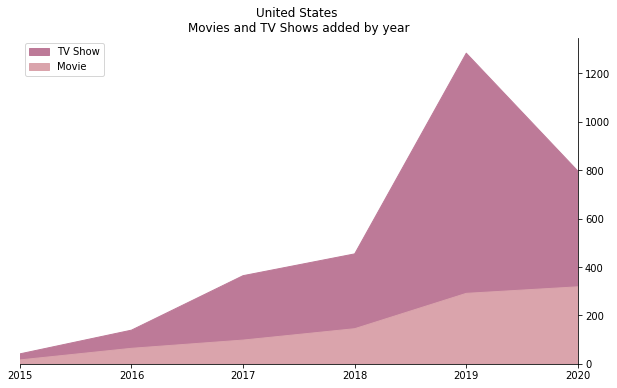

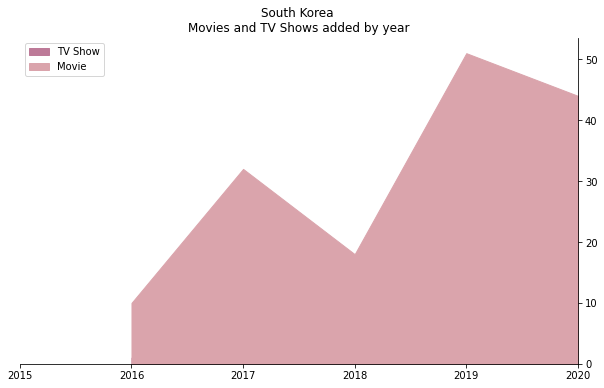

In [ ]:
added_year_country(country1, 'United States')
added_year_country(country1, 'South Korea')


Country-Wise Analysis of Most Popular Age-Groups

In [ ]:
country2=country.copy()
country2['country']=country['country'].str.split(', ')
country2=country2.explode('country')
Movie_t=country2[country2['type']=='Movie'].dropna(subset=['length'])
TV_s=country2[country2['type']=='TV Show'].dropna(subset=['num_seasons'])

country2=country2[~country2['rating'].isin(['NOT RATED'])]
df=country2.loc[country2['platform'] == 'netflix']
x=country2.groupby('country')['rating'].value_counts().unstack().loc[country2['country'].value_counts().index[:10]]
x.columns=['Kids','Older Kids', 'Teens', 'Adults']
x=x.T

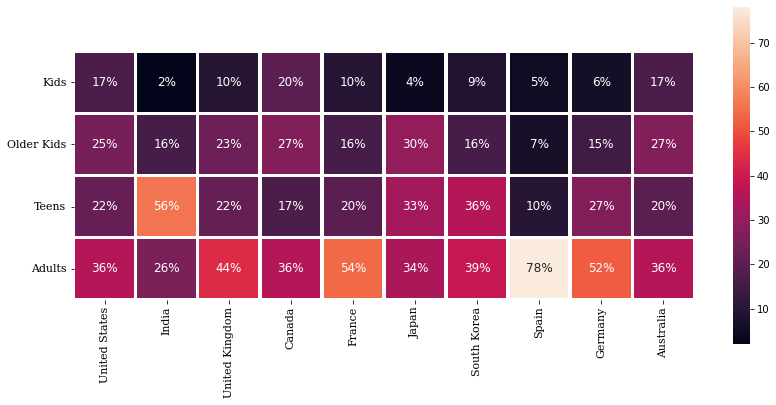

In [ ]:
country_order2 = ['USA', 'India', 'UK', 'Canada', 'Japan', 'France', 'South Korea', 'Spain',
       'Mexico', 'Japan']

age_order = ['Kids','Older Kids','Teens','Adults']
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
im=sns.heatmap(round(x*100/x.sum()), square=True,cbar=True,cbar_kws={"shrink": .4},linewidth=2.5,fmt="1.0f", annot=True,ax=ax,annot_kws={"fontsize":12})
for t in im.texts: t.set_text(t.get_text() + "%")
ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)
ax.set_ylabel('')    
ax.set_xlabel('')
#ax.set_title('Netflix')
plt.tight_layout()
plt.show()

Average duration of Movies

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

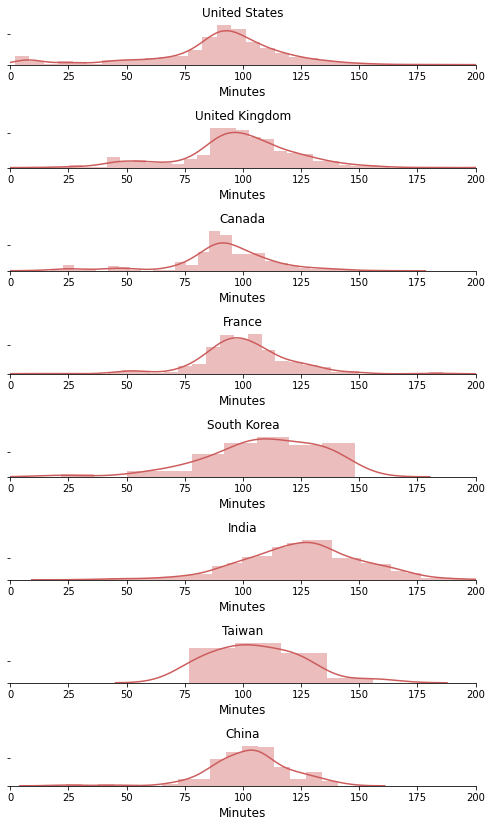

In [ ]:
fig, ax = plt.subplots(8,1,figsize=(8,12))
fig.tight_layout(pad=4)
countries=['United States','United Kingdom', 'Canada','France', 'South Korea', 'India','Taiwan', 'China']

def country_platform_movie(Movie_t,country,ax,c):
  M=Movie_t.copy()
  MT=M[M['country']==country]
  ax.set_title(f'{country}')
  sns.distplot(MT['length'], ax=ax, color=c[0])
  #ax.legend(country)
  ax.spines['top'].set_visible(False)  
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.set_ylabel('')
  ax.set_yticklabels('')
  ax.set_xlim(0,200)
  ax.set_xlabel('Minutes', fontsize = 12)
  #ax.set_ylabel(platform, fontsize = 15)

for i in range(8):
    country_mov_duration=country_platform_movie(Movie_t,countries[i],ax[i], netflix_p)